# Default Setup

In [0]:
# Dataloading Stuff
from google.colab import drive
from sys import path
import os

# Standard Stuff
!pip3 install numpy sklearn iterative-stratification pandas pyss3
from sklearn.model_selection import train_test_split

from pyss3 import SS3
from pyss3.util import Dataset, Evaluation, span

import numpy as np
import pandas as pd

drive.mount('/content/drive', force_remount=True)
path_root = '/content/drive/My Drive/NLP Lab/SingleLabel/'
path.append(path_root)
data_root = 'data/'

     |████████████████████████████████| 2.0MB 3.8MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Classifier with 5 Classes

Classification: 100%|██████████| 630/630 [00:00<00:00, 48596.07it/s]



              precision    recall  f1-score   support

           1       0.30      0.24      0.27        25
           2       0.12      0.23      0.16        13
           3       0.26      0.38      0.31        24
           4       0.30      0.37      0.33        99
           5       0.84      0.77      0.80       469

    accuracy                           0.66       630
   macro avg       0.36      0.40      0.37       630
weighted avg       0.70      0.66      0.68       630


 Accuracy: 0.659

[ updating evaluations cache ]


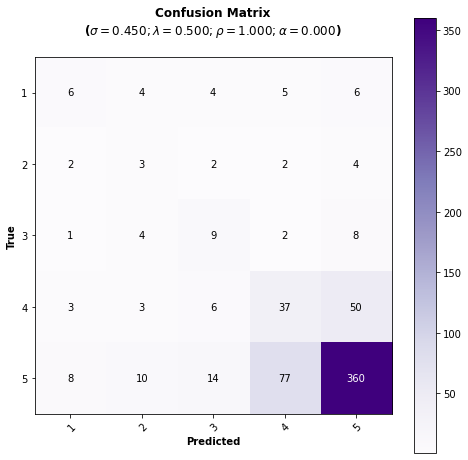

0.3739844986418309

In [0]:
df = pd.read_csv(path_root + data_root + "AmazonAlexaReview/amazon_alexa.tsv", sep="\t")
text = df['verified_reviews'].to_list()
labels = df['rating'].astype(str).to_list()

X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.2)
clf5 = SS3()
clf5.fit(X_train, y_train)
Evaluation.test(clf5, X_val, y_val, metric="f1-score")

## Classifier with 2 Classes

Classification: 100%|██████████| 630/630 [00:00<00:00, 44578.10it/s]



              precision    recall  f1-score   support

    negative       0.45      0.74      0.56        62
    positive       0.97      0.90      0.93       568

    accuracy                           0.88       630
   macro avg       0.71      0.82      0.75       630
weighted avg       0.92      0.88      0.90       630


 Accuracy: 0.884

[ updating evaluations cache ]


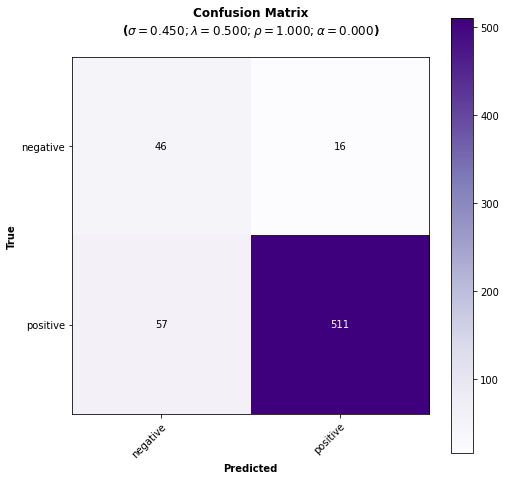

0.7454545454545454

In [0]:
y_train_two = pd.Series(y_train).astype(str).replace(to_replace={'1': 'negative', '2': 'negative', '3': 'negative', '4': 'positive', '5': 'positive'}, regex=True).to_list()
y_val_two = pd.Series(y_val).astype(str).replace(to_replace={'1': 'negative', '2': 'negative', '3': 'negative', '4': 'positive', '5': 'positive'}, regex=True).to_list()

clf2 = SS3()
clf2.fit(X_train, y_train_two)
Evaluation.clear_cache()
Evaluation.test(clf2, X_val, y_val_two, metric="f1-score")

## Calculate the all word overlap
1. Get dictionaries
2. Use dictionaries to find overlaping words

In [0]:
!rm -rf vocab_five && mkdir vocab_five
!rm -rf vocab_two && mkdir vocab_two
clf2.save_vocab(path="./vocab_two")
clf5.save_vocab(path="./vocab_five")

In [0]:
def get_vocab(vocab_dir, attribute):
  list_of_vocabs = {}

  for filename in os.listdir(vocab_dir):
    csv_file = pd.read_csv(vocab_dir + filename)
    list_of_vocabs[filename] = csv_file

  for key, value in list_of_vocabs.items():
    list_of_vocabs[key] = list_of_vocabs[key][["term", attribute]]

  return list_of_vocabs

vocab_five = get_vocab('./vocab_five/', 'fr')
vocab_two = get_vocab('./vocab_two/', 'fr')

In [0]:
def convert_to_df(list_of_vocabs, attribute):
  terms = []
  for key, value in list_of_vocabs.items():
    terms = list(set(list_of_vocabs[key]["term"].tolist()) | set(terms))
  pd.Series(terms).value_counts()

  new_keys = ["term"]
  for value in list(list_of_vocabs.keys()):
    if "bigram" not in value and "trigram" not in value:
      new_keys.append(value)

  data = np.zeros((len(terms), len(new_keys)))
  # Generate Empty Dataframe
  new_vocab = pd.DataFrame(data=data, columns = new_keys, dtype=float)
  new_vocab["term"] = terms
  new_vocab = new_vocab.set_index("term")

  # Fill Dataframe with values
  for key, value in list_of_vocabs.items():
    if "bigrams" in key:
      key = key.replace("bigrams", "words")
    if "trigrams" in key:
      key = key.replace("trigrams", "words")
    for index, row in value.iterrows():
      new_vocab[key][row["term"]] = row[attribute]
  return new_vocab

five_df = convert_to_df(vocab_five, 'fr')
two_df = convert_to_df(vocab_two, 'fr')

In [0]:
five_df

,ss3_vocab_2(words).csv,ss3_vocab_1(words).csv,ss3_vocab_5(words).csv,ss3_vocab_4(words).csv,ss3_vocab_3(words).csv
term,,,,,
green,0.0,0.0,2.0,0.0,0.0
despite,0.0,0.0,2.0,0.0,0.0
thick,0.0,0.0,0.0,2.0,0.0
yourself,0.0,0.0,3.0,0.0,2.0
tablet,0.0,0.0,2.0,0.0,2.0
...,...,...,...,...,...
lives,0.0,0.0,9.0,0.0,0.0
links,0.0,0.0,2.0,0.0,0.0
directv,0.0,0.0,3.0,0.0,0.0


In [0]:
from collections import defaultdict

def calc_word_overlap(vocab_df, important=False, a=None):
  overlap = defaultdict(int)
  counter_all = 0

  for keys, row in vocab_df.iterrows():
    if not important:
      if np.count_nonzero(row) > 1:
        indices = row.to_numpy().nonzero()
        res_keys = vocab_df.keys()[indices[0]]
        overlap[tuple(res_keys)] += 1
        counter_all += 1
    else:
      if np.count_nonzero(row.ge(a)) > 1:
        indices = np.where(row.to_numpy() > a)
        res_keys = vocab_df.keys()[indices[0]]
        overlap[tuple(res_keys)] += 1
        counter_all += 1
  return overlap, counter_all

five_overlap, five_counter = calc_word_overlap(five_df)
two_overlap, two_counter = calc_word_overlap(two_df)

In [0]:
sorted(five_overlap.items(), key=lambda kv: kv[1], reverse=True)

[(('ss3_vocab_5(words).csv', 'ss3_vocab_4(words).csv'), 186),
 (('ss3_vocab_5(words).csv',
   'ss3_vocab_4(words).csv',
   'ss3_vocab_3(words).csv'),
  77),
 (('ss3_vocab_5(words).csv', 'ss3_vocab_3(words).csv'), 61),
 (('ss3_vocab_1(words).csv',
   'ss3_vocab_5(words).csv',
   'ss3_vocab_4(words).csv',
   'ss3_vocab_3(words).csv'),
  59),
 (('ss3_vocab_1(words).csv', 'ss3_vocab_5(words).csv'), 51),
 (('ss3_vocab_2(words).csv',
   'ss3_vocab_5(words).csv',
   'ss3_vocab_4(words).csv'),
  48),
 (('ss3_vocab_1(words).csv',
   'ss3_vocab_5(words).csv',
   'ss3_vocab_4(words).csv'),
  47),
 (('ss3_vocab_2(words).csv',
   'ss3_vocab_5(words).csv',
   'ss3_vocab_4(words).csv',
   'ss3_vocab_3(words).csv'),
  38),
 (('ss3_vocab_2(words).csv',
   'ss3_vocab_1(words).csv',
   'ss3_vocab_5(words).csv',
   'ss3_vocab_4(words).csv'),
  22),
 (('ss3_vocab_2(words).csv', 'ss3_vocab_5(words).csv'), 18),
 (('ss3_vocab_2(words).csv',
   'ss3_vocab_1(words).csv',
   'ss3_vocab_5(words).csv',
   'ss3_voc

In [0]:
sorted(two_overlap.items(), key=lambda kv: kv[1], reverse=True)

[(('ss3_vocab_positive(words).csv', 'ss3_vocab_negative(words).csv'), 752)]

In [0]:
print('Counter 5 Classes:', five_counter, ' Counter 2 Classes:', two_counter)
print('5 Classes Ratio:', five_counter/five_df.shape[0], ' 2 Classes Ratio:', two_counter/two_df.shape[0])

Counter 5 Classes: 714  Counter 2 Classes: 752
5 Classes Ratio: 0.40044868199663486  2 Classes Ratio: 0.36700829673011226


## Calculate the important word overlap

In [0]:
a = clf2.get_a()
vocab_two_cv = get_vocab('./vocab_two/', 'cv')
vocab_five_cv = get_vocab('./vocab_five/', 'cv')
vocab_two_cv_df = convert_to_df(vocab_two_cv, 'cv')
vocab_five_cv_df = convert_to_df(vocab_five_cv, 'cv')
two_overlap_cv, two_counter_cv = calc_word_overlap(vocab_two_cv_df)#, important=True, a=a)
five_overlap_cv, five_counter_cv = calc_word_overlap(vocab_five_cv_df)#, important=True, a=a)
vocab_five_cv_df

,ss3_vocab_2(words).csv,ss3_vocab_1(words).csv,ss3_vocab_5(words).csv,ss3_vocab_4(words).csv,ss3_vocab_3(words).csv
term,,,,,
green,0.0,0.0,0.193000,0.000000,0.000000
despite,0.0,0.0,0.193000,0.000000,0.000000
thick,0.0,0.0,0.000000,0.408824,0.000000
yourself,0.0,0.0,0.087892,0.000000,0.202552
tablet,0.0,0.0,0.072226,0.000000,0.204885
...,...,...,...,...,...
lives,0.0,0.0,0.384678,0.000000,0.000000
links,0.0,0.0,0.192405,0.000000,0.000000
directv,0.0,0.0,0.234139,0.000000,0.000000


In [0]:
#sorted(five_overlap_cv.items(), key=lambda kv: kv[1], reverse=True)

In [0]:
#two_overlap_cv

In [0]:
print('Counter 5 Classes:', five_counter_cv, ' Counter 2 Classes:', two_counter_cv)
print('5 Classes Ratio:', five_counter_cv/vocab_five_cv_df.shape[0], ' Counter 2 Classes:', two_counter_cv/vocab_two_cv_df.shape[0])

Counter 5 Classes: 714  Counter 2 Classes: 700
5 Classes Ratio: 0.40044868199663486  Counter 2 Classes: 0.3416300634455832


In [0]:
vocab_five_cv_df.apply(np.count_nonzero, axis=0)

ss3_vocab_2(words).csv     254
ss3_vocab_1(words).csv     323
ss3_vocab_5(words).csv    1356
ss3_vocab_4(words).csv     648
ss3_vocab_3(words).csv     377
dtype: int64

In [0]:
five_df.apply(np.count_nonzero, axis=0)

ss3_vocab_2(words).csv     214
ss3_vocab_1(words).csv     302
ss3_vocab_5(words).csv    1433
ss3_vocab_4(words).csv     747
ss3_vocab_3(words).csv     358
dtype: int64

$\Rightarrow$ Different numbers between frequency and CV meaning there are terms, for which the frequency is not zero, but the CV is zero.

In [0]:
vocab_five_cv_df.rename(columns={'ss3_vocab_1(words).csv': '1(words)', 'ss3_vocab_2(words).csv': '2(words)', 'ss3_vocab_3(words).csv': '3(words)', 'ss3_vocab_4(words).csv': '4(words)', 'ss3_vocab_5(words).csv': '5(words)'}, inplace=True)
tmp_df = pd.concat([vocab_five_cv_df, five_df], axis=1)
tmp_df[tmp_df['ss3_vocab_2(words).csv'] != 0.0]['2(words)'].value_counts().keys().sort_values()

Float64Index([               7.2e-05,               0.000205,
                            0.000258,               0.000259,
                            0.000267, 0.00028199999999999997,
                            0.000294,               0.000365,
                            0.000376, 0.00045599999999999997,
              ...
                            0.590654,               0.592279,
                            0.613354,               0.663654,
                            0.674138,               0.791908,
                            0.802767,               0.802798,
                            0.852879,                    1.0],
             dtype='float64', length=179)

This difference seems to just be a rounding error (7.2e-05)